## imports

In [ ]:
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import numpy.random as npr
from jax import jit, grad
from functools import partial
from jax import value_and_grad
import jax
from jax import jit
from matplotlib import pyplot
import matplotlib.pyplot as plt
import copy
from jax import vmap ### Batching an ODE Net

from copy import deepcopy

## NN functions define

In [ ]:

'''
`mlp` is simply a composition of linear and nonlinear layers.  
Its parameters `params` are a list of weight matrices and bias vectors.
To make larger models, we can always chain together or compose layers.  
'''

def relu(x):
  return jnp.maximum(0.0, x)


#### our controller h(x,t)
'''
`mlp` is simply a composition of linear and nonlinear layers.  
Its parameters `params` are a list of weight matrices and bias vectors.
To make larger models, we can always chain together or compose layers.  
'''

def relu(x):
  return jnp.maximum(0.0, x)


# #### our controller h(x,t)
# def mlp_control(params, inputs):
#     """ Compute the forward pass for each example individually """
#     activations = inputs
#     # Loop over the ReLU hidden layers
#     for w, b in params[:-1]:
#         activations = jax.nn.elu(jnp.dot(activations,w) + b)
#     # Perform final trafo to logits
#     final_w, final_b = params[-1]
#     # logits = jnp.tanh(jnp.dot(activations, final_w) + final_b)

#     logits = jnp.dot(activations, final_w) + final_b
#     return logits


#### our dynamic learner g(x,u,t) 
def mlp_dyn(params, inputs, control):
  inputs_ = jnp.hstack([inputs, jnp.array(control)])
  for w, b in params:
    outputs = jnp.dot(inputs_, w) + b  # Linear transform
    inputs_ = jnp.tanh(outputs)            # Nonlinearity
    # inputs_ = jax.nn.elu(outputs)

  # outputs = jnp.tanh(inputs_)   
  return outputs


'''
To fit this model to data, we also need a loss, an initializer, and an optimizer: 
'''

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]


#### our dynamic learner g(x,u,t) 
def mlp_dyn(params, inputs, control):
  inputs_ = jnp.hstack([inputs, jnp.array(control)])
  for w, b in params:
    outputs = jnp.dot(inputs_, w) + b  # Linear transform
    inputs_ = jnp.tanh(outputs)            # Nonlinearity
    # inputs_ = jax.nn.elu(outputs)

  # outputs = jnp.tanh(inputs_)   
  return outputs


'''
To fit this model to data, we also need a loss, an initializer, and an optimizer: 
'''

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

## Define neural dynamics
This is our $\dot x = \hat g(x,\hat h(x, \theta), \gamma)$ \\

In [ ]:
# def nn_unknown_dynamics_with_control(state, time, params): #dx/dt = g(x,u)

def nn_unknown_dynamics_with_control(state, time, params): #dx/dt = g(x,u)
  params_dyn, params_control = params
  state_and_time = jnp.hstack([state, jnp.array(time)])
  u = mlp_control(params_control,state_and_time)
  # u = mlp_control(params_control,state)
  return mlp_dyn(params_dyn, state, u) ## dx/dt = g(x,u)


#### integrate g with odeint
def ode_control_net(params, input, n_points=10, mode = 'train_with_sequence'): 
  # print("!!!!!!! end time for ode net is {}".format(end_time))
  start_and_end_times = jnp.array([0.0, end_time])
  n_points = int(end_time*10+1) ## make sure that multi-stage train always include the same points

  if mode not in ['train_with_sequence', 'train_with_end_data', 'return_control']:
      print("Mode error")

  if mode == 'train_with_sequence':
      TS = jnp.linspace(0, end_time, n_points)
      final_state = input
      sequence = odeint(nn_unknown_dynamics_with_control, final_state, TS, params, atol=0.001, rtol=0.001)
      return sequence

  elif mode == 'return_control': ## can do this as we only return control when do testing, and no need for batching there
      all_controls = []
      sequence = [input]
      TS = jnp.linspace(0, end_time, n_points)## fix n_points for all the nets
      final_state = input
    
      for i in range(len(TS)-1):
          state_and_time = jnp.hstack([final_state, jnp.array(TS[i])])
          params_control = params[1]
          control_used =  np.sum(np.array(mlp_control(params_control,state_and_time))**2) # call controler mlp here, need to only use part of params as well
          control_used = control_used*start_and_end_times[-1]/n_points
          all_controls.append(control_used)

          inter_start_and_end_times = jnp.array([TS[i], TS[i+1]])
          init_state, final_state = odeint(nn_unknown_dynamics_with_control, final_state, inter_start_and_end_times, params, atol=0.001, rtol=0.001)
          sequence.append(list(jnp.array(final_state)))
   
      # all_controls = np.asarray(all_controls).cumsum()
      return jnp.asarray(sequence),all_controls ## return [y0,y1,y2,y3,...], [a0,a1,a2,a3,...]

  elif mode == 'train_with_end_data':
      init_state, final_state = odeint(nn_unknown_dynamics_with_control, input, start_and_end_times, params, atol=0.001, rtol=0.001)
      return final_state


def ode_control_net_controller_train(params, input):
    # start_and_end_times = jnp.array([0.0, 1.0]) #### this shall always be 1 ? 
    start_and_end_times = jnp.array([0.0, end_time]) #### this shall always be 1 ? 
    init_state, final_state = odeint(nn_unknown_dynamics_with_control, input, start_and_end_times, params, atol=0.001, rtol=0.001)
    return final_state





## Create loss functions 
For both dyn: $\hat g(x,\hat h(x, \theta), \gamma)$ training and controller: $h(x, \theta)$ training

For $\hat g(x,\hat h(x, \theta), \gamma)$ training, we input sequence of true y and actions we use in f by plugging in $h(x, \theta)$

In [ ]:
# @partial(jit, static_argnums=(1,3,4))
def odenet_loss_dyn(params, inputs, targets_from_real_env):
  # params = params_dyn, params_control
  preds = batched_odenet(params, inputs)
  loss = jnp.mean(jnp.sum(jnp.abs(preds - targets_from_real_env),axis=1)) ## !!!!! this loss seem to make things better
  # loss = jnp.mean(jnp.sum((preds - targets_from_real_env)**2, axis=1))
  return loss

@jit
def odenet_update_dyn(params, inputs, targets_from_real_env): 
  '''
  Input: current params (tuple) before update, input data in a batch 
  Return: updated dyn_params, fixed con_params, 
  '''
  loss, grads = value_and_grad(odenet_loss_dyn)(params, inputs, targets_from_real_env) # can get grad and loss in one path: https://github.com/google/jax/issues/4857
  grad_dyn = grads[0]
  grad_control = grads[1]
  # print("The grad norm is {}".format(np.sum(grads[0][0][0]**2)/len(grads[0][0][0])))

  dyn_params = [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params[0], grad_dyn)]
  con_params = [(w, b)
          for (w, b), (dw, db) in zip(params[1], grad_control)]

  return dyn_params, con_params, loss

In [ ]:
def odenet_loss_control(params, inputs,targets):
  preds = batched_odenet_controller_train(params, inputs)
  loss = jnp.mean(jnp.sum((preds - targets)**2, axis=1))
  return loss

@jit
def odenet_update_control(params, inputs, targets):
  loss, grads = value_and_grad(odenet_loss_control)(params, inputs, targets)
  grad_dyn = grads[0]
  grad_control = grads[1]

  dyn_params = [(w , b )
          for (w, b), (dw, db) in zip(params[0], grad_dyn)]
  con_params = [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params[1], grad_control)]
  
  return dyn_params, con_params, loss

## Create visualization functions

plot traj rollout

plot vector field 

In [ ]:
#### this function plots the traj rollout calling mode 'return_control', which use scipy odeint --> no trace (no gradient stuff)
import seaborn as sns

def plot_current(params,data_batch, task = "AxBu"):
    if task == "AxBu":

        controls_real = []
        controls_odenet = []

        sns.set_style('whitegrid')  # Set seaborn style for better visual aesthetics

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Plotting trajectories
        ax_traj = axes[0]
        ax_traj.set_xlabel('x1')
        ax_traj.set_ylabel('x2')

        m = 0
        for start in data_batch:
            traj_real, all_controls_real = real_net(params, start, mode='return_control')
            traj_ode, all_controls_ode = ode_control_net(params, start, mode='return_control')
            controls_real.append(all_controls_real)
            controls_odenet.append(all_controls_ode)
            if m == 0:
                ax_traj.plot(traj_real[:, 0], traj_real[:, 1], linewidth=1, color='black', label='Roll-out in real dynamics f')
                ax_traj.plot(traj_ode[:, 0], traj_ode[:, 1], linewidth=1, color='red', label='Roll-out in learned dynamics g')
            else:
                ax_traj.plot(traj_real[:, 0], traj_real[:, 1], linewidth=1, color='black')
                ax_traj.plot(traj_ode[:, 0], traj_ode[:, 1], linewidth=1, color='red')

            ax_traj.plot(start[0], start[1], marker='o', markersize=4, markeredgecolor='red', markerfacecolor='green')
            m += 1

        ax_traj.scatter(1, -1, s=200, c='blue', marker='+', label='Target State')
        ax_traj.legend()

        # Plotting control signals
        ax_ctrl = axes[1]
        ax_ctrl.set_xlabel('Time')
        ax_ctrl.set_ylabel('Control u')

        for i in range(len(controls_real)):
            if i == 0:
                ax_ctrl.plot(np.array(controls_real[i]).T, c='black', linestyle='-', label='Control used in f')
                ax_ctrl.plot(np.array(controls_odenet[i]).T, c='r', linestyle='--', label='Control used in g')
            else:
                ax_ctrl.plot(np.array(controls_real[i]).T, c='black', linestyle='-')
                ax_ctrl.plot(np.array(controls_odenet[i]).T, c='r', linestyle='--')

        ax_ctrl.legend()

        plt.tight_layout()
        plt.show()



    
    elif task == "CartPole":
        for input in data_batch[0:1]:
            print("From real dynamics")
            result,controls_f = real_net_cart(params,input,mode='return_control')
            position_result = result[:,0]
            v_result = result[:,1]
            angle_result = result[:,2]
            angular_result = result[:,3]

            # print("the loss is {}".format(result[:,-1]))
            plt.plot(position_result,label='position x',linewidth=1)
            plt.plot(v_result,label='velocity x dot',linewidth=1)
            plt.plot(angle_result,label='angle theta',linewidth=1)
            plt.plot(angular_result,label='angular velocity theta dot',linewidth=1)
            plt.legend()
            plt.ylim([-2, 2])
            plt.show()

            ##############
            print("From learned dynamics")
            result, controls_g = ode_control_net(params,input, mode='return_control')

            position_result = result[:,0]
            v_result = result[:,1]
            angle_result = result[:,2]
            angular_result = result[:,3]

            # print("the loss is {}".format(result[:,-1]))
            plt.plot(position_result,label='position x',linewidth=1)
            plt.plot(v_result,label='velocity x dot',linewidth=1)
            plt.plot(angle_result,label='angle theta',linewidth=1)
            plt.plot(angular_result,label='angular velocity theta dot',linewidth=1)
            plt.legend()
            plt.ylim([-2, 2])
            plt.show()

            print("Compare controls")
            plt.plot(controls_f, label = "real")
            plt.plot(controls_g, label = "learned")
            # print(min(controls_f))
            # plt.ylim([-0.2, 0.2])
            plt.legend()
            plt.show()
            print("################################################")
            print()


## Task: Ax+Bu

### Define real dynamics
This is our $\dot x = f(x,u)$ 

In [ ]:
#### our controller h(x,t)
##  i.e. a fully-connected neural network.
def mlp_control(params, inputs):
  for w, b in params:
    outputs = jnp.dot(inputs, w) + b  # Linear transform
    inputs = jnp.tanh(outputs)            # Nonlinearity
  return outputs


end_time = 1.0
#### real dyanmical function f(x,u)
def real_dynamics(state, time, params):
  params_dyn, params_control = params
  # ################################### for plotting vector field, in general, should not do this
  # time = 0
  # ###################################
  state_and_time = jnp.hstack([state, jnp.array(time)])
  u = mlp_control(params_control, state_and_time)
  outputs = jnp.dot(A, state) + jnp.dot(B, u)
  return outputs
  
#### integrate f with odeint
def real_net(params, input, n_points=10, mode = 'train_with_sequence'): 
  start_and_end_times = jnp.array([0.0, end_time])
  # print("!!!!!!! end time for real net is {}".format(end_time))

  n_points = int(end_time*10+1)

  if mode not in ['train_with_sequence', 'train_with_end_data','return_control']:
      print("Mode error")

  if mode == 'train_with_sequence': 
      TS = jnp.linspace(0, end_time, n_points)
      final_state = input
      sequence = odeint(real_dynamics, final_state, TS, params, atol=0.001, rtol=0.001)
      return sequence

  elif mode == 'return_control': ## can do this as we only return control when do testing, and no need for batching there
      all_controls = []
      sequence = [input]
      TS = jnp.linspace(0, end_time, n_points)
      # TS = jnp.linspace(0, end_time, n_points)
      final_state = input
      for i in range(len(TS)-1):
          state_and_time = jnp.hstack([final_state, jnp.array(TS[i])])
          params_control = params[1]
          control_used =  jnp.sum(jnp.array(mlp_control(params_control,state_and_time))**2) # call controler mlp here, need to only use part of params as well
          control_used = control_used*start_and_end_times[-1]/n_points
          all_controls.append(control_used)
          inter_start_and_end_times = jnp.array([TS[i], TS[i+1]])
          init_state, final_state = odeint(real_dynamics, final_state, inter_start_and_end_times, params, atol=0.001, rtol=0.001)
          sequence.append(list(jnp.array(final_state)))
   
      # all_controls = np.asarray(all_controls).cumsum()
      return jnp.asarray(sequence),all_controls

  elif mode == 'train_with_end_data':
      init_state, final_state = odeint(real_dynamics, input, start_and_end_times, params, atol=0.001, rtol=0.001)
      return final_state


### define problem params

In [ ]:

# total time for control
T = 1
# we evaluate two points in time, first point is matched to initial
# state and  second one is matched to the terminal state
t = jnp.linspace(0, T, 2)

# batched of initial states:
# x0_batch = jnp.round(jnp.mgrid[-0.2:0:0.05, -0.2:0:0.05].reshape(2,-1).T,1)
x0_batch = jnp.array([[-0.2, -0.2],
             [-0.2, -0.1],
             [-0.1, -0.2],
             [-0.1, -0.1],
             [0, -0.1]])
x0_batch_control = x0_batch


# batched target state, all -1,1
x_target = jnp.asarray([
    1, -1
])
x_target_batch = jnp.tile(x_target,(len(x0_batch_control),1))

# ''' 
# A very simple control task
# '''
# interaction matrix
A = jnp.asarray(
    [[0., 1.],
    [1., 0.]
])

# driver matrix
B = jnp.asarray([
    [1.],
    [0.]
])

# for visualizations
x = np.arange(-4,2,0.1)
y = np.arange(-2,1,0.1)

## --> for dyn train
batched_odenet = vmap(ode_control_net, in_axes=(None, 0)) 
batched_real = vmap(real_net, in_axes=(None, 0))

#### current problem: vmap can not input mode argument, so need to redefine ode_control net for each stage 
## --> for con train
batched_odenet_controller_train = vmap(ode_control_net_controller_train, in_axes=(None, 0))

param_scale_con = 0.5
param_scale_dyn = 0.5

# control_layer_size = [3, 10, 1] # input dim: state_time, layer size, output dim 1-control dimension

control_layer_size = [3, 30, 1]  # input dim: state_time (2+1), layer size, output dim
dyn_layer_size = [3, 30, 2] # input dim: state_control (2+1), layer size, output dim


params_dyn = init_random_params(param_scale_dyn, dyn_layer_size)
params_control = init_random_params(param_scale_con, control_layer_size)

odenet_params = params_dyn,params_control

# step_size = 0.005
step_size = 0.001

### Training Ax+Bu

In [ ]:


def dyn_train_multi_rollot_with_plot(params,iter_per_stage,data_batch):
    # list_of_end_times = [0.05,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

    # list_of_end_times = [0.4,0.8,1]
    list_of_end_times = [1]
    # list_of_end_times = [1]
    Loss = []
    global end_time
    for end_time in list_of_end_times:
        print()
        print("########### Move to next end time {}".format(end_time))
        y_sequence_true = batched_real(params,data_batch)
        # print("y_sequence_true: ", y_sequence_true[0])
        y_sequence_true = np.array(y_sequence_true)

        count = 0 ## for early stopping
        for i in range(iter_per_stage):
            dyn_params, con_params, loss = odenet_update_dyn(params, data_batch, y_sequence_true)
            params = dyn_params, con_params
           
            Loss.append(loss)
            if i%int(iter_per_stage/5)==0:
                print(loss)
                plot_current(params,data_batch)

            if len(Loss)>=2:
                if Loss[-2] < Loss[-1]:
                    count+=1
            if count>=1000:
                break ## early stopping

    plt.plot(Loss)
    plt.xlabel('Training Iterations')
    plt.ylabel('Dynamics learner Loss')
    plt.show()

    return params

In [ ]:


def con_train_with_plot(params,con_iter,data_batch):
    Loss = []
    count = 0
    for i in range(con_iter):
        params_dyn,params_control,loss = odenet_update_control(params, data_batch, x_target_batch)
        if i%(con_iter/10)==0:
          print(loss)
        params = params_dyn,params_control
        Loss.append(loss)
        if len(Loss)>=2:
            if Loss[-2] < Loss[-1]:
                count+=1
        if count>=2000:
            break ## early stopping

    print("Finish controller training, plot loss:")
    plt.plot(Loss)
    plt.xlabel('Training Iterations')
    plt.ylabel('Controller Loss')
    plt.show()

    return params

Get adversial / non-sensible examples

In [ ]:
# odenet_params = con_train_with_plot(odenet_params,50000,x0_batch)

In [ ]:
# plot_current(odenet_params,x0_batch)

#########################################################
Alternation 0
#########################################################
start dyn

########### Move to next end time 1
11.739303


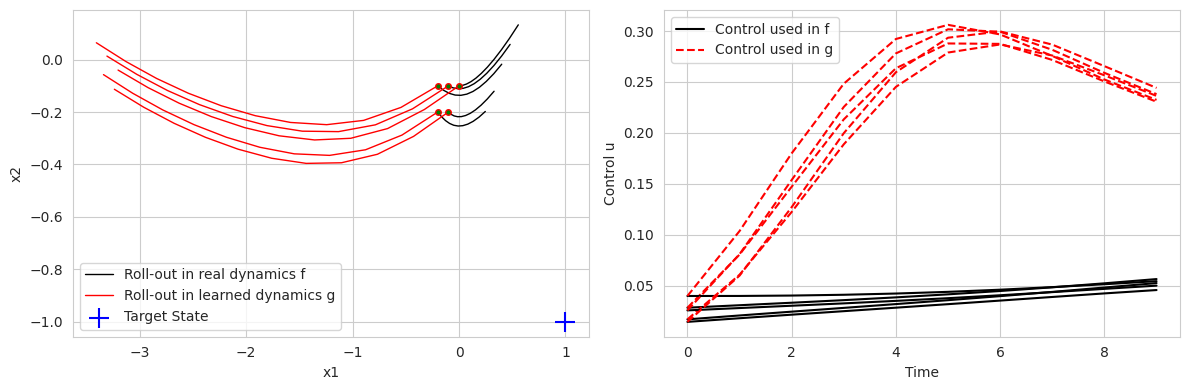

0.58122927


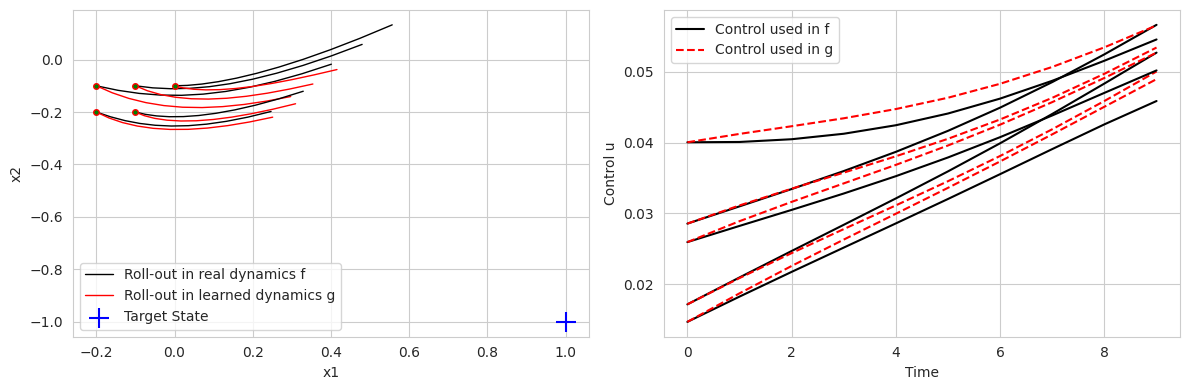

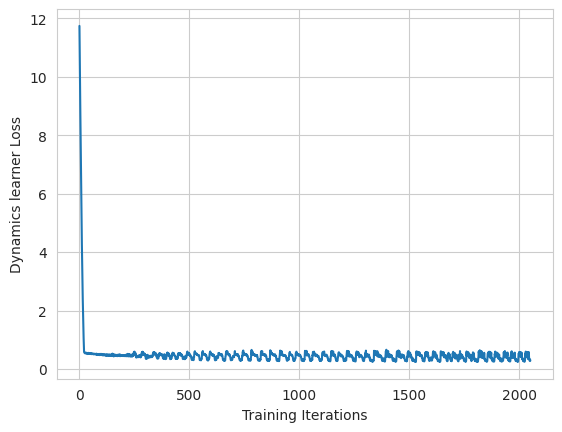

start con
1.2805105
0.8510947
0.83698696
0.84211844
0.8412561
Finish controller training, plot loss:


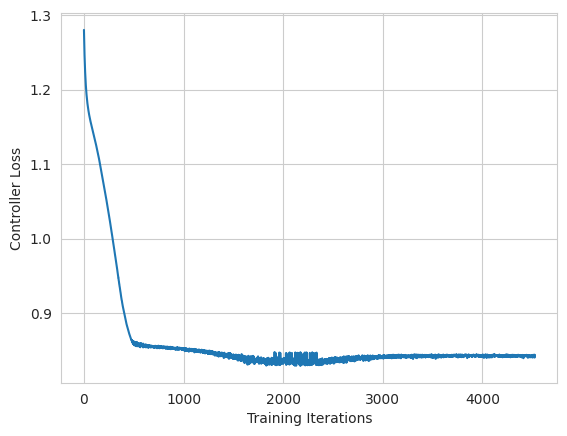


#########################################################
Alternation 1
#########################################################
start dyn

########### Move to next end time 1
1.9448467


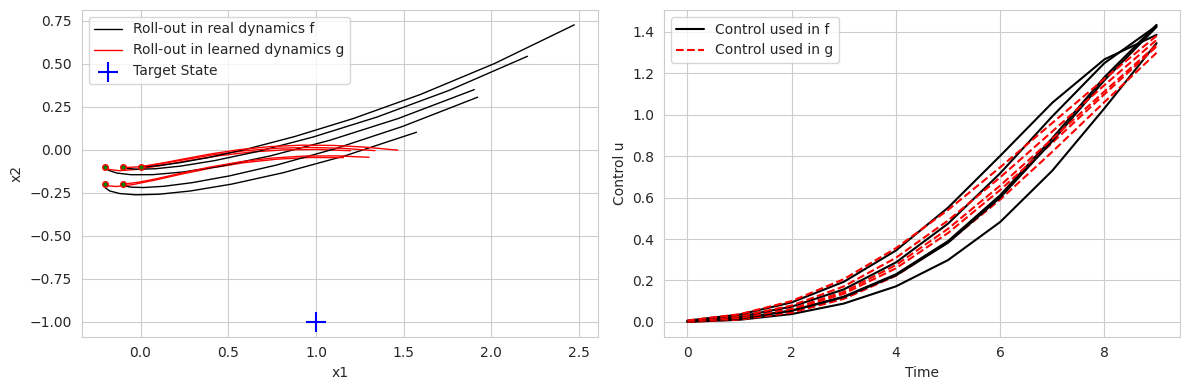

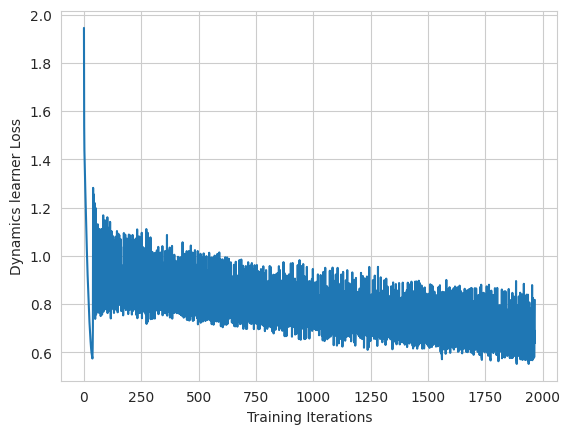

start con
2.2613175
0.8718421
0.868682
0.8665744
0.86501324
Finish controller training, plot loss:


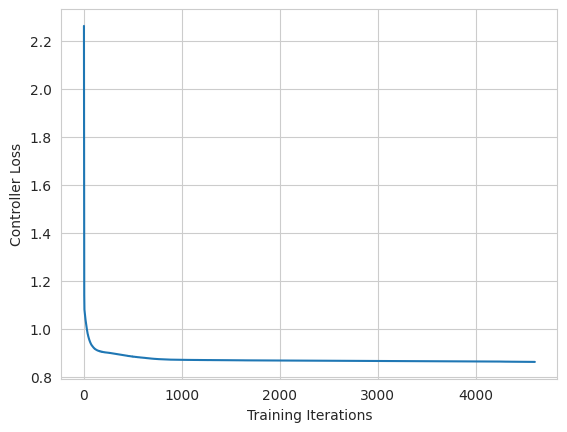


#########################################################
Alternation 2
#########################################################
start dyn

########### Move to next end time 1
0.55272347


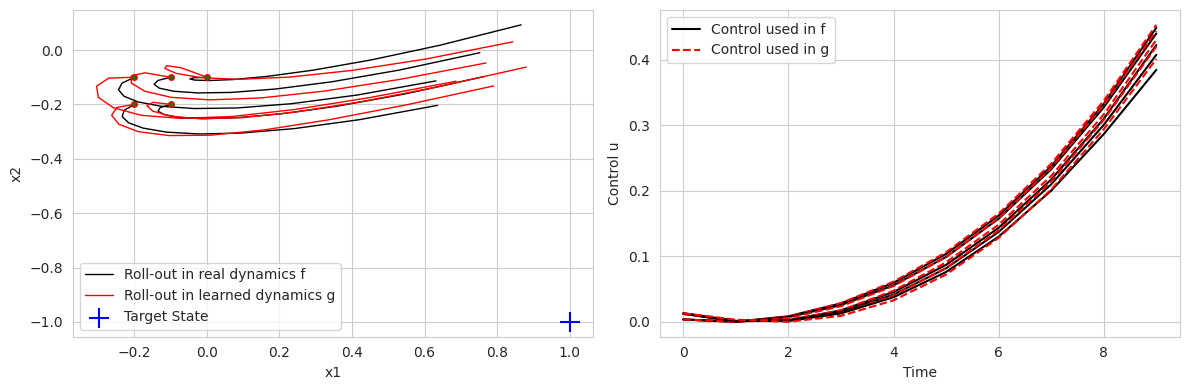

0.19298272


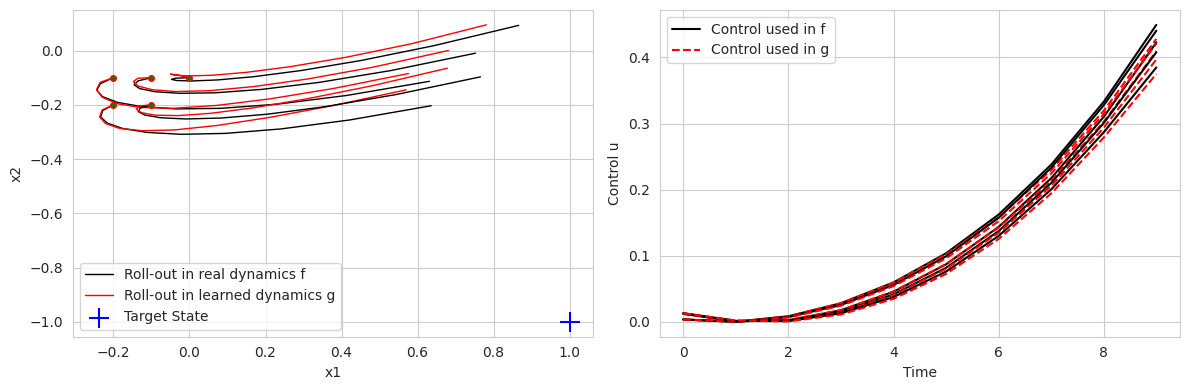

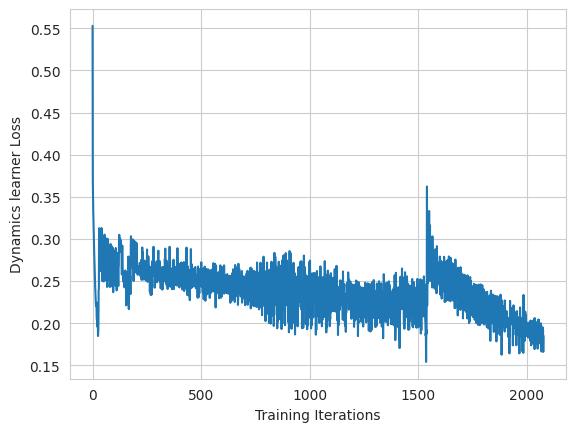

start con
1.0409576
0.97649735
0.9729096
0.9704041
0.9677827
Finish controller training, plot loss:


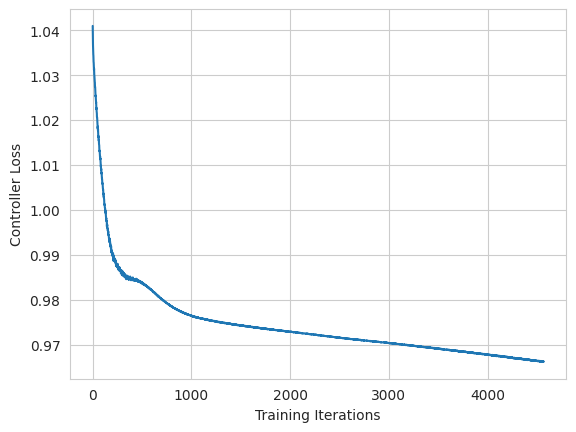


#########################################################
Alternation 3
#########################################################
start dyn

########### Move to next end time 1
0.44600034


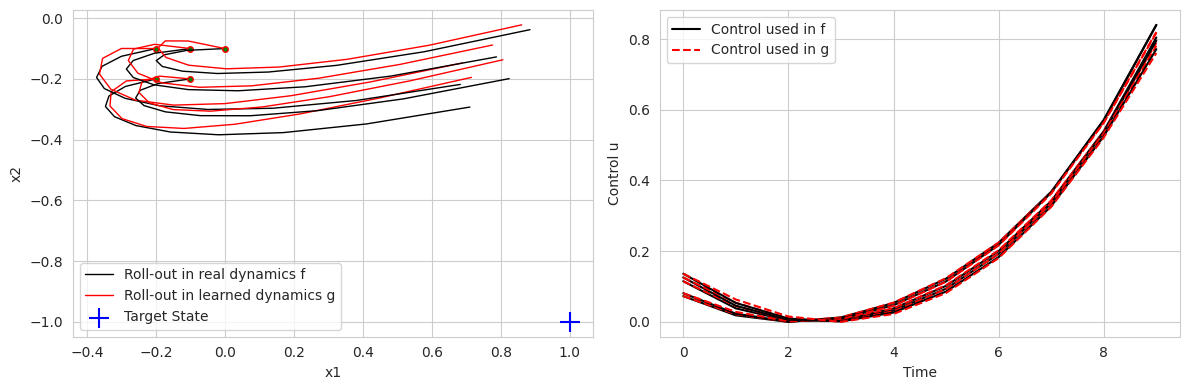

0.14776917


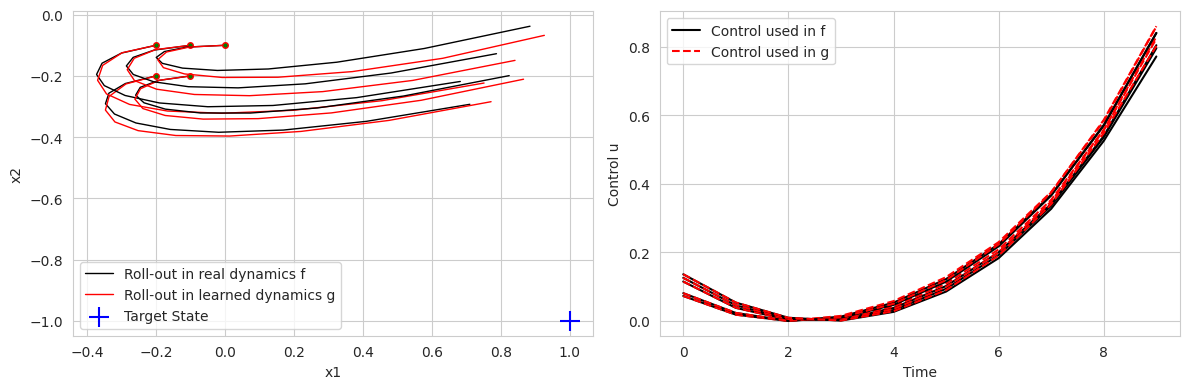

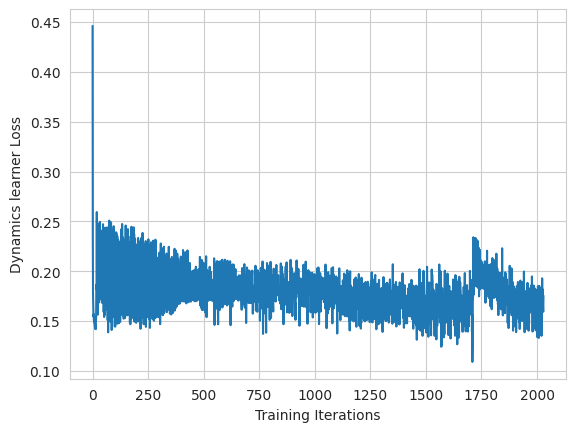

start con
0.81288064
0.73378444
0.7177613
0.7161309
0.7165739
Finish controller training, plot loss:


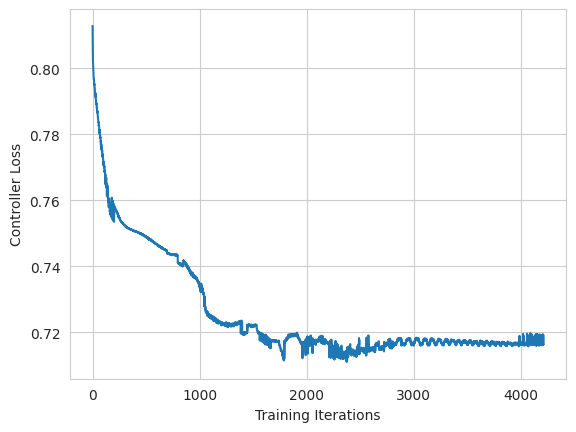


#########################################################
Alternation 4
#########################################################
start dyn

########### Move to next end time 1
0.51000494


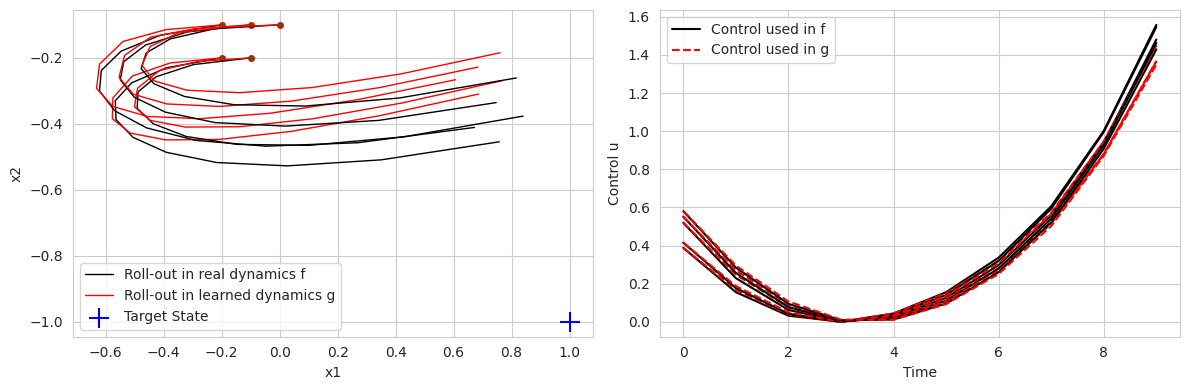

0.16365138


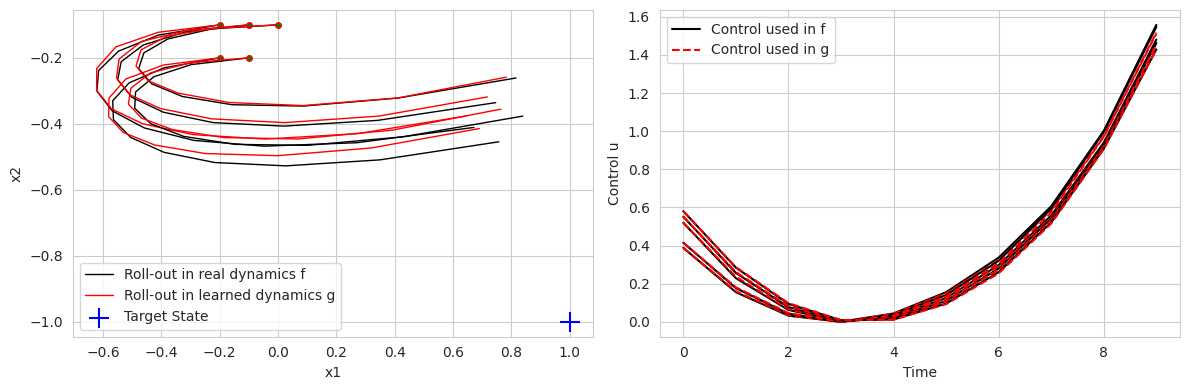

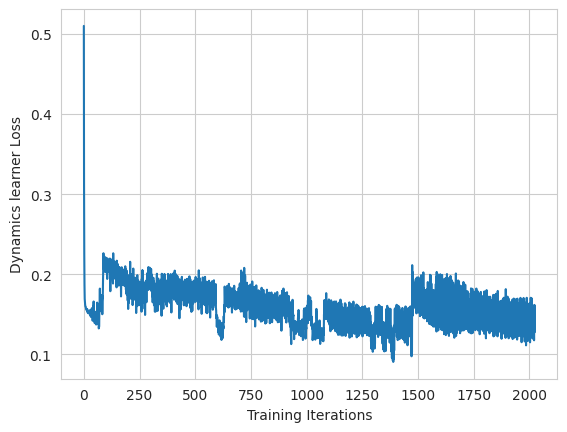

start con
0.49513277
0.41760945
0.43153116
0.4243509
0.42611438
Finish controller training, plot loss:


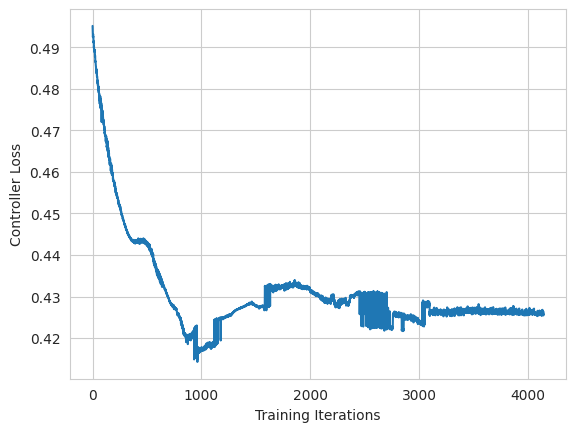


#########################################################
Alternation 5
#########################################################
start dyn

########### Move to next end time 1
0.7989174


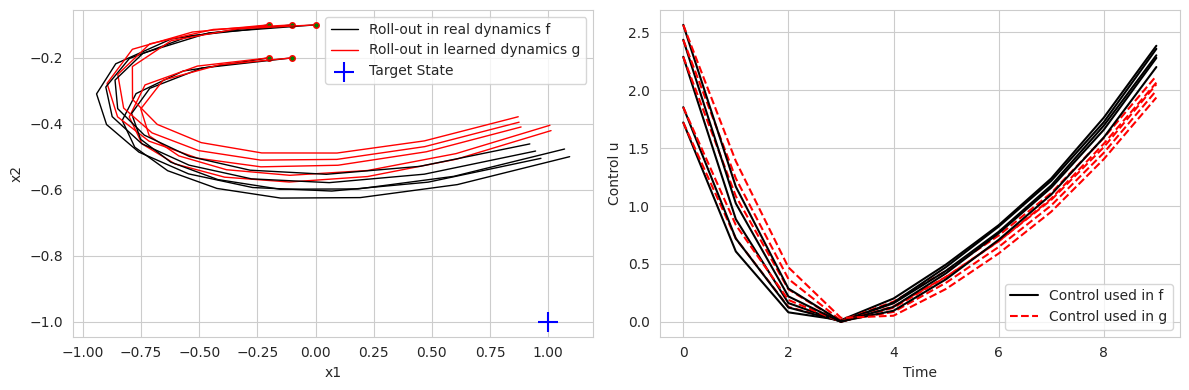

0.21052372


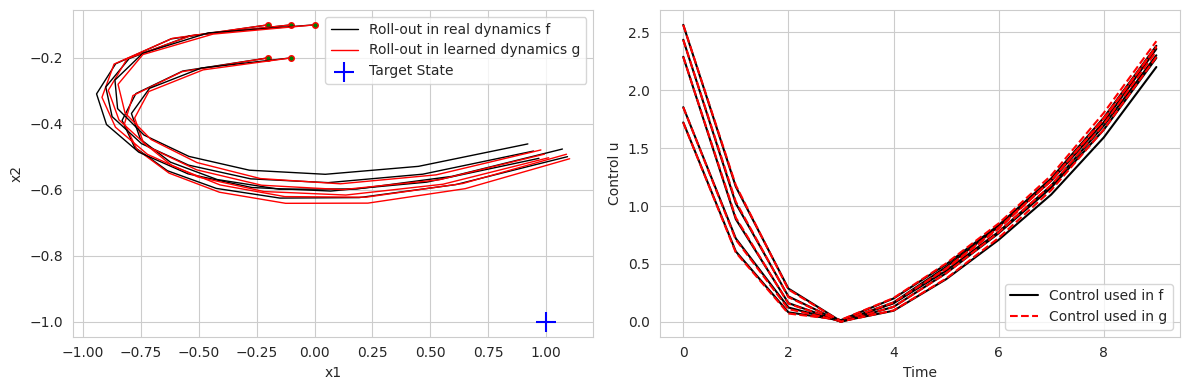

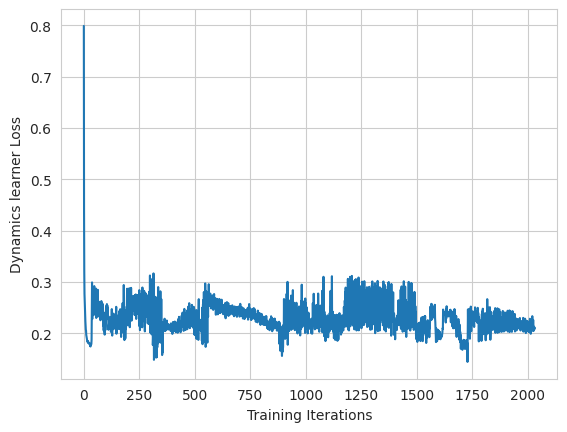

start con
0.2577531
0.18626927
0.1825438
0.18065886
0.17911305
Finish controller training, plot loss:


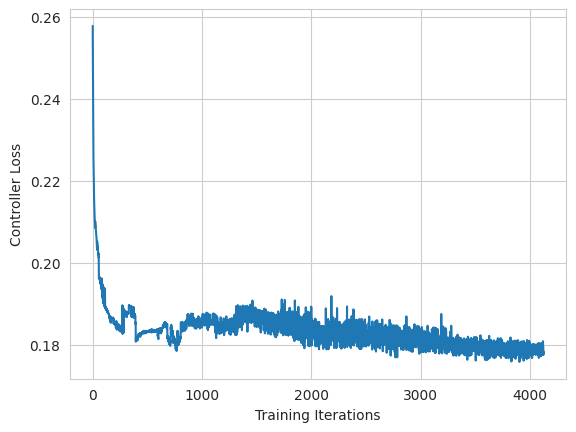


#########################################################
Alternation 6
#########################################################
start dyn

########### Move to next end time 1
0.4220007


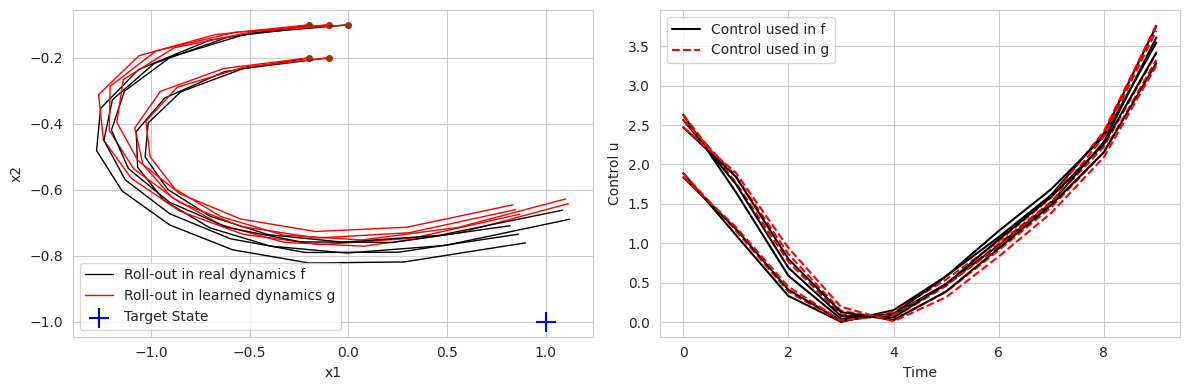

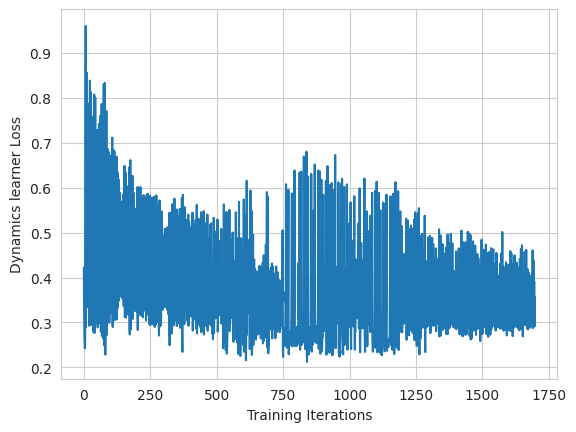

start con
0.0868738
0.054983567
0.03982528
0.04212741
0.04415354
Finish controller training, plot loss:


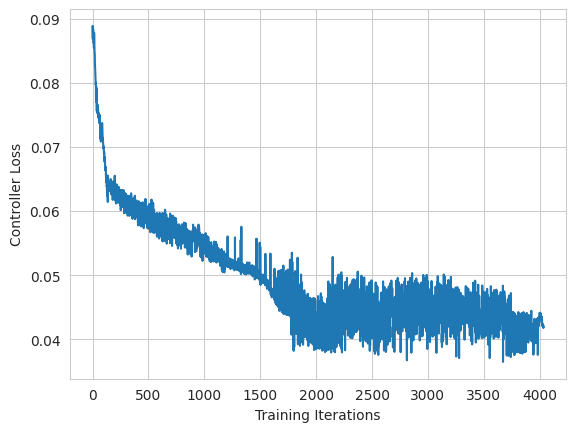


#########################################################
Alternation 7
#########################################################
start dyn

########### Move to next end time 1
0.6377186


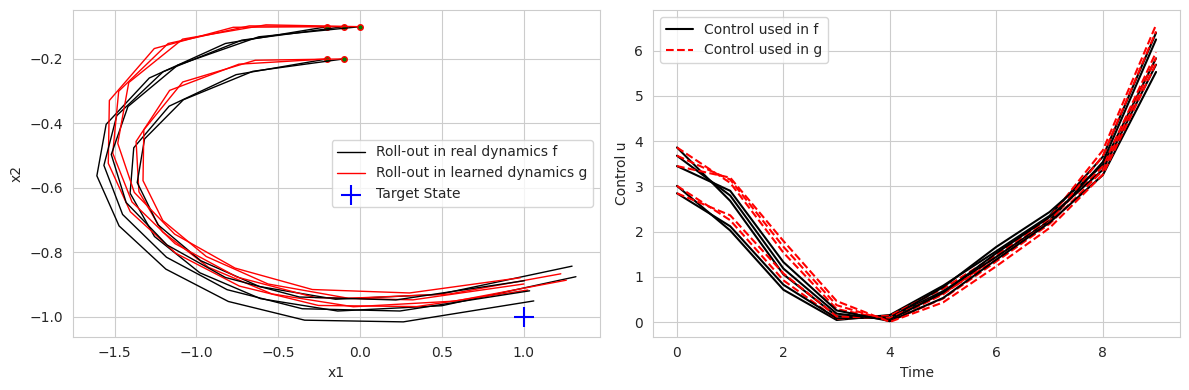

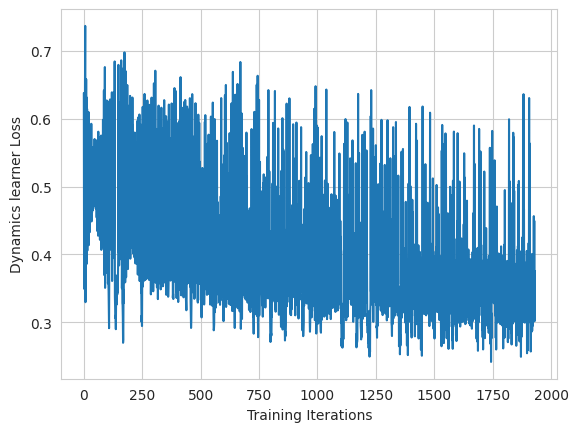

start con
0.011522121
0.011018525
0.010831969
0.010834135
0.011831112
Finish controller training, plot loss:


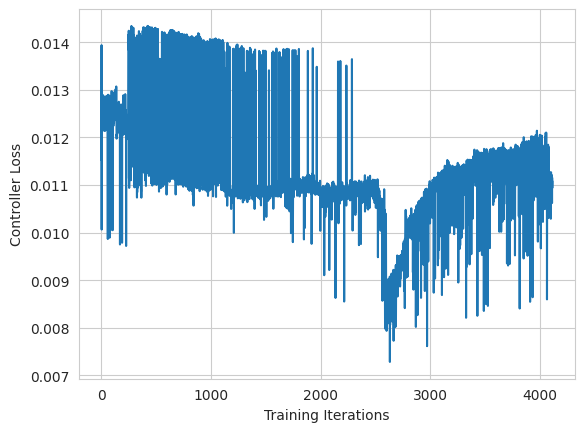


#########################################################
Alternation 8
#########################################################
start dyn

########### Move to next end time 1
0.40432253


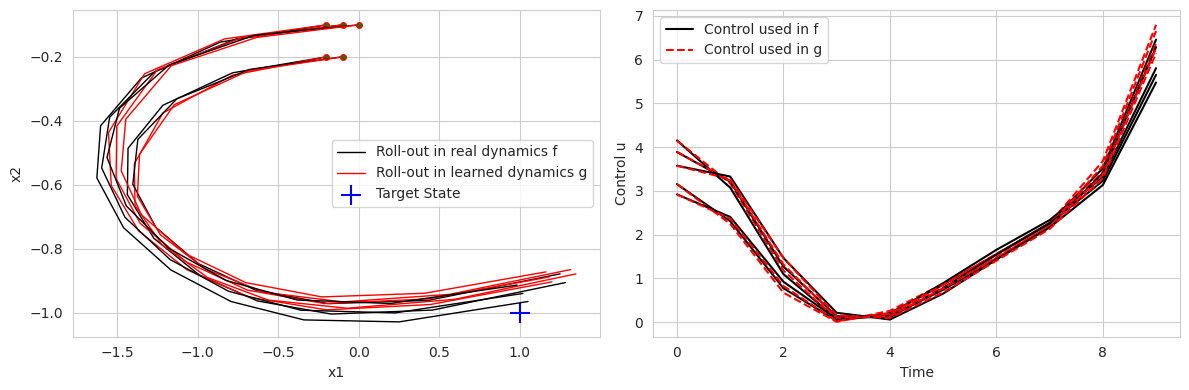

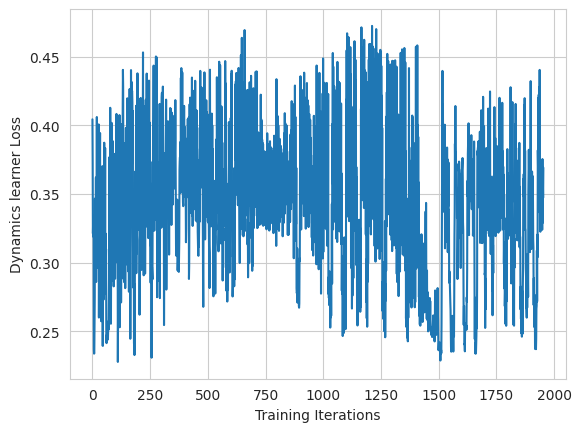

start con
0.06066963
0.0058936975
0.005354873
0.004647005
0.004258026
Finish controller training, plot loss:


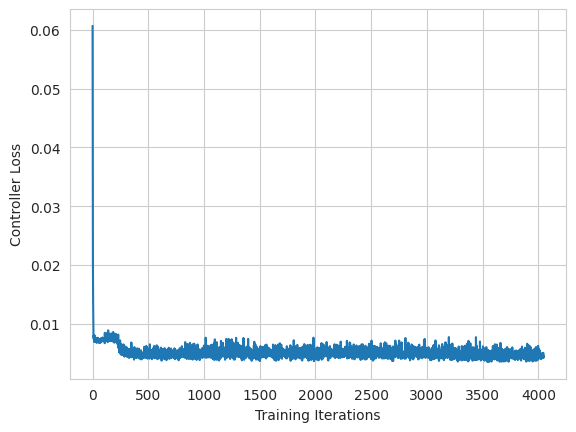


#########################################################
Alternation 9
#########################################################
start dyn

########### Move to next end time 1
0.51730454


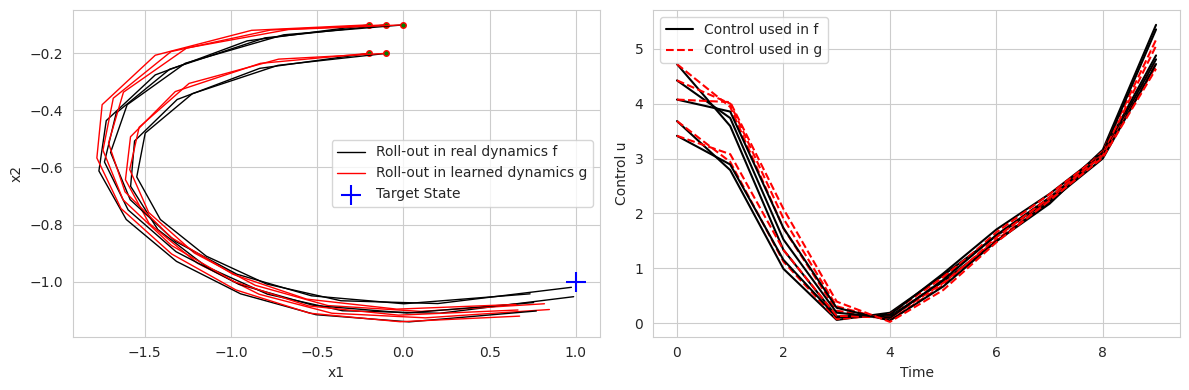

0.25291833


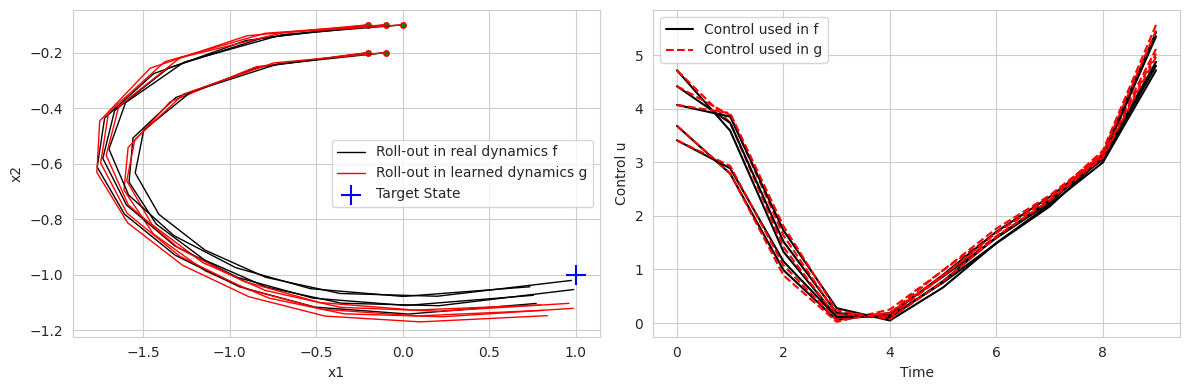

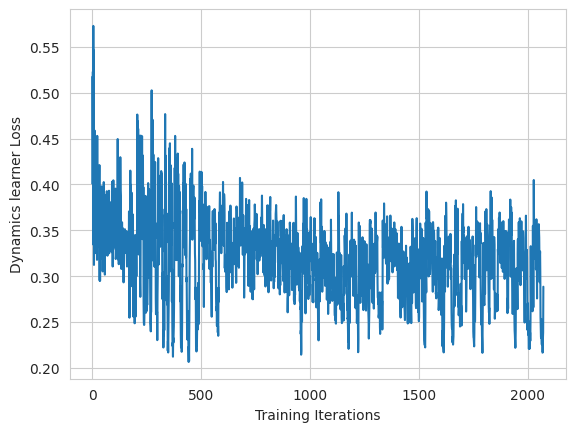

start con
0.057766356
0.0037272747
0.006741428
0.006237086
0.005016515
Finish controller training, plot loss:


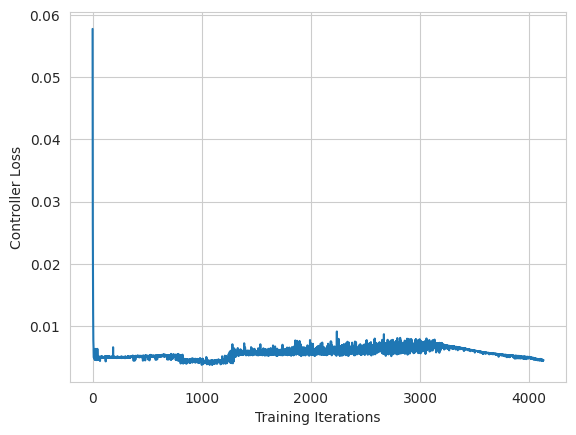


#########################################################
Alternation 10
#########################################################
start dyn

########### Move to next end time 1
0.29948044


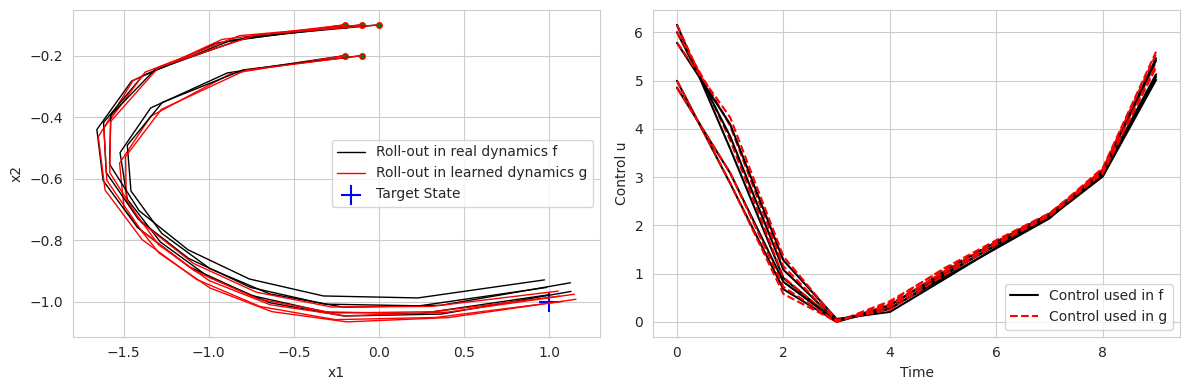

0.24731874


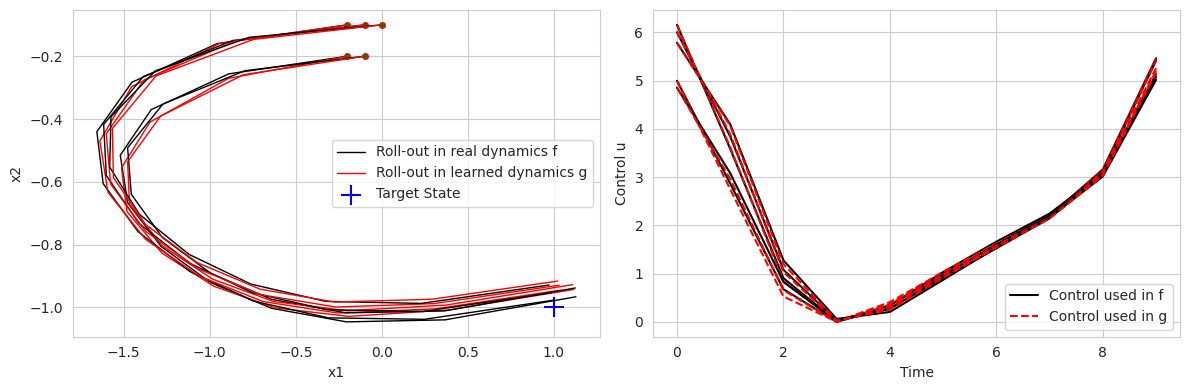

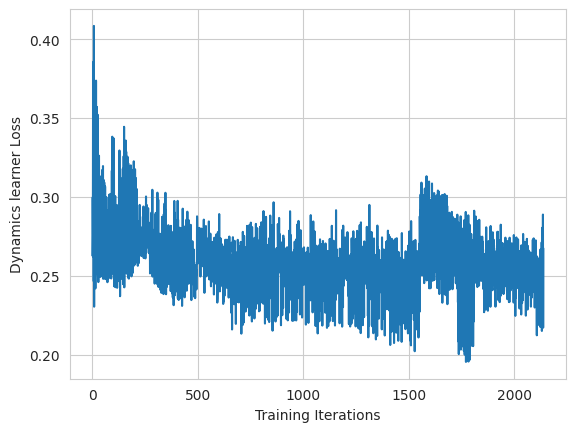

start con
0.009347607
0.0021981844
0.0017952698
0.0031191779
0.0016086219
Finish controller training, plot loss:


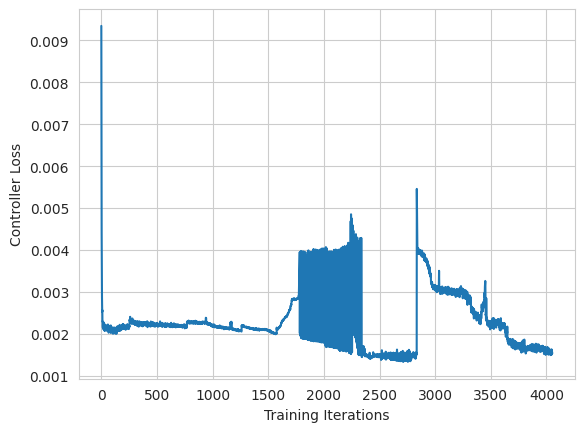

In [ ]:


alternation = 10
k=0
step_size=0.005
while k <= alternation:
    print("#########################################################")
    print("Alternation {}".format(k))
    print("#########################################################")
    print("start dyn")
    odenet_params = dyn_train_multi_rollot_with_plot(odenet_params,10000, x0_batch)
    print("start con")
    odenet_params = con_train_with_plot(odenet_params,10000,x0_batch)
    print()
    k+=1



### Some testing of dyn learner

out of distribution vector field etc

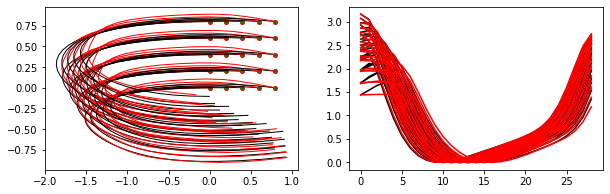

In [ ]:
x0_batch_more = jnp.round(jnp.mgrid[0:1:0.2, 0:1:0.2].reshape(2,-1).T,1)
controls_real = []
controls_odenet = []

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1) # row 1, col 2 index 1

for start in x0_batch_more:
    traj_real,all_controls_real = real_net(odenet_params, start, mode='return_control')
    traj_ode,all_controls_ode = ode_control_net(odenet_params, start, mode='return_control')

    controls_real.append(all_controls_real)
    controls_odenet.append(all_controls_ode)

    plt.plot(traj_real[:,0],traj_real[:,1], linewidth=1, color = 'black')
    plt.plot(traj_ode[:,0],traj_ode[:,1], linewidth=1, color = 'red')
    plt.plot(start[0],start[1],marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green", label="Start")


plt.subplot(1, 2, 2) # index 2
plt.plot(np.array(controls_real).T,c='black')
plt.plot(np.array(controls_odenet).T,c='r')
plt.show()